# Support Vector Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Generate synthetic dataset

In [3]:
# Generate sinusoidal data
np.random.seed(200)
x = np.random.uniform(low=-10, high=10, size=50)
x = np.sort(x)

# Generate t, with random Gaussian noise
t = np.sin(x/1.5)
e = np.random.normal(size=t.shape[0], scale=0.1)
t = t + e

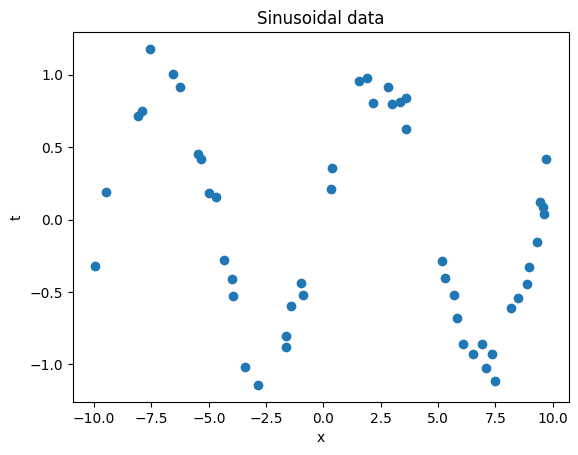

In [4]:
# Plot x and t
plt.scatter(x, t)
plt.xlabel('x')
plt.ylabel('t')
plt.title('Sinusoidal data')
plt.show()